In [1]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from arch.bootstrap import SPA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

In [2]:

list_of_period = [5,10,15,20,25,30]
list_of_k = [1,1.5,2]
period = 20
k = 2

# # Read the data from the Excel file
# xls_file = '/home/vishi/bolinger/cumul_ohlc.xls'
# xls = xlrd.open_workbook(xls_file)
# sheet = xls.sheet_by_index(0)
# # the sheet is like this 
# # DateTime	open	high	low	close
# # 20241231~09:16:00	2355950	2356430	2354005	2355135

# df = pd.read_excel(xls_file, sheet_name=0, usecols="A:E", header=0)
# # Convert the DateTime column to datetime format
# df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d~%H:%M:%S')
# df["close_scaled_down"] = df["close"] / 1000
df = pd.read_csv('/home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv', index_col=0, parse_dates=True)



In [3]:
# # add a moving average column
# df['MA'] = df['close'].rolling(window=period).mean()
# # add a Bollinger Bands column
# df['Upper_Band'] = df['MA'] + k * df['close'].rolling(window=period).std()
# df['Lower_Band'] = df['MA'] - k * df['close'].rolling(window=period).std()



In [4]:
def strategy_profit(closing_prices, mid_band, lower_band, upper_band):
    
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                buy_signal.append(i)
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                sell_signal.append(i)
        elif position == 'long':
            if closing_prices[i] >mid_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < mid_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
    return profit, buy_signal, sell_signal

In [5]:
def strategy_profit_with_stop_loss(closing_prices, mid_band, lower_band, upper_band, stop_loss = 0.1):
    
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    entry_price = 0
    stop_loss_price = 0
    profit_ts = []
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 - stop_loss)/ 100
                buy_signal.append(i)
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 + stop_loss)/ 100
                sell_signal.append(i)
        elif position == 'long':
            if closing_prices[i] > mid_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
            elif closing_prices[i] < stop_loss_price :
                profit -= entry_price - closing_prices[i]
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < mid_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
            elif closing_prices[i] > stop_loss_price :
                profit -= closing_prices[i] - entry_price
                position = None
                buy_signal.append(i)

        profit_ts.append(profit)
    return profit_ts, buy_signal, sell_signal

In [6]:
# ===============================================================================================
def func_of_arima_1_1_1(t_1_data, t_2_data, ar_param, ma_param, prev_residual):
    """
    Calculate the ARIMA(1,1,1) value based on previous data and parameters.
    
    :param t_1_data: Previous time series data point (t-1)
    :param t_2_data: Previous time series data point (t-2)
    :param ar_param: AR parameter
    :param ma_param: MA parameter
    :param prev_residual: Previous residual
    :return: Computed value for the current time step
    """
    return ar_param * (t_1_data - t_2_data) + ma_param * prev_residual + t_1_data

def func_of_garch_1_1(omega, alpha, beta, prev_volatility, prev_residual):
    """
    Calculate the GARCH(1,1) value based on previous volatility and residuals.
    :param omega: Constant term
    :param alpha: Coefficient for lagged squared residuals
    :param beta: Coefficient for lagged volatility
    :param prev_volatility: Previous volatility
    :param prev_residual: Previous residual
    :return: Computed volatility for the current time step
    """
    return np.sqrt(omega + alpha * prev_residual ** 2 + beta * prev_volatility**2)

def forecast_closing_prices(df,steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-02-01",
                            order_arima=(1, 1, 1), order_garch=(1, 1) ):
    df_filtered = df.loc[startdate:end_date]
    df_prediction = df.loc[df.index > end_date]


    arima_model = ARIMA(df_filtered['close_scaled_down'], order=order_arima)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        arima_fit = arima_model.fit()
    residual_np = np.array(arima_fit.resid)
    

    garch_model = arch_model(residual_np, vol='Garch', p=order_garch[0], q=order_garch[1])
    garch_fit = garch_model.fit(disp="off")

    ma_param = arima_fit.maparams[0]
    ar_param = arima_fit.arparams[0]

    prediction_arima = []
    residual_prediction = []    

    prediction_arima.append(func_of_arima_1_1_1(
        df_filtered['close_scaled_down'].iloc[-1],
        df_filtered['close_scaled_down'].iloc[-2],
        ar_param,
        ma_param,
        residual_np[-1]
    ))

    residual_prediction.append(df_prediction['close_scaled_down'][0] - prediction_arima[-1])

    prediction_arima.append(func_of_arima_1_1_1(
        prediction_arima[-1],
        df_filtered['close_scaled_down'].iloc[-1],
        ar_param,
        ma_param,
        residual_prediction[-1]
    ))
    residual_prediction.append(df_prediction['close_scaled_down'][1] - prediction_arima[-1])
    for i in range(2, steps):
        prediction_arima.append(func_of_arima_1_1_1(
            prediction_arima[-1],
            prediction_arima[-2],
            ar_param,
            ma_param,
            residual_prediction[-1]
        ))
        residual_prediction.append(df_prediction['close_scaled_down'][i] - prediction_arima[-1])

    garch_params = garch_fit.params
    omega = garch_params['omega']
    alpha = garch_params['alpha[1]']
    beta = garch_params['beta[1]']

    vol_garch = garch_fit.conditional_volatility
    volatility_prediction = []

    volatility_prediction.append(func_of_garch_1_1(
        omega,
        alpha,
        beta,
        vol_garch[-1],
        residual_np[-1]
    ))

    for i in range(1, steps):
        volatility_prediction.append(func_of_garch_1_1(
            omega,
            alpha,
            beta,
            volatility_prediction[-1],
            residual_prediction[i-1]
        ))

    return arima_fit, garch_fit, prediction_arima, residual_prediction, volatility_prediction


In [ ]:
arima_fit_forecast, garch_fit_forecast, prediction_arima, residual_prediction, volatility_prediction = forecast_closing_prices(
    df, steps=7875, startdate="2024-12-31", end_date="2025-02-01 09:00",
    order_arima=(1, 1, 1), order_garch=(1, 1)
)
upper_band = np.array(prediction_arima) + 2 * np.array(volatility_prediction)
lower_band = np.array(prediction_arima) - 2 * np.array(volatility_prediction)
mid_band = np.array(prediction_arima)


plt.figure(figsize=(12, 6))
plt.plot(mid_band[:500], label='Predicted Returns Percent', color='blue')
plt.plot(upper_band[:500], label='Upper Band', color='green')
plt.plot(lower_band[:500], label='Lower Band', color='red')
# plt.plot(resid_pred_xyz, label='Residuals of Predicted Returns Percent', color='orange')
plt.plot(np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])[:500], label='Original Data', color='purple')
plt.title('Predicted Returns Percent')
plt.xlabel('DateTime')
plt.ylabel('Returns Percent')
plt.legend()
plt.grid()
plt.show()

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipykernel_1226/475674830.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

IndexError: index 0 is out of bounds for axis 0 with size 0

In [47]:
# create a DataFrame for the forecasts
data = df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00']
forecast_df = pd.DataFrame({
    'forecast_mid': mid_band,
    'forecast_vol': volatility_prediction,
}, index=data.index[:])
# save the forecast DataFrame to a CSV file
forecast_df.to_csv('/home/vishi/bolinger/forecast_mid_and_vol_non_rolling.csv')

In [49]:
# find rmse of the forecast
rmse = np.sqrt(np.mean((data[:len(mid_band)] - mid_band) ** 2))
print(f"RMSE of the forecast: {rmse}")
# R-squared of the forecast
r_squared = 1 - (np.sum((data[:len(mid_band)] - mid_band) ** 2) / np.sum((data[:len(mid_band)] - np.mean(data[:len(mid_band)])) ** 2))
print(f"R-squared of the forecast: {r_squared}")

RMSE of the forecast: 1.3827085793816805
R-squared of the forecast: 0.9990771215104374


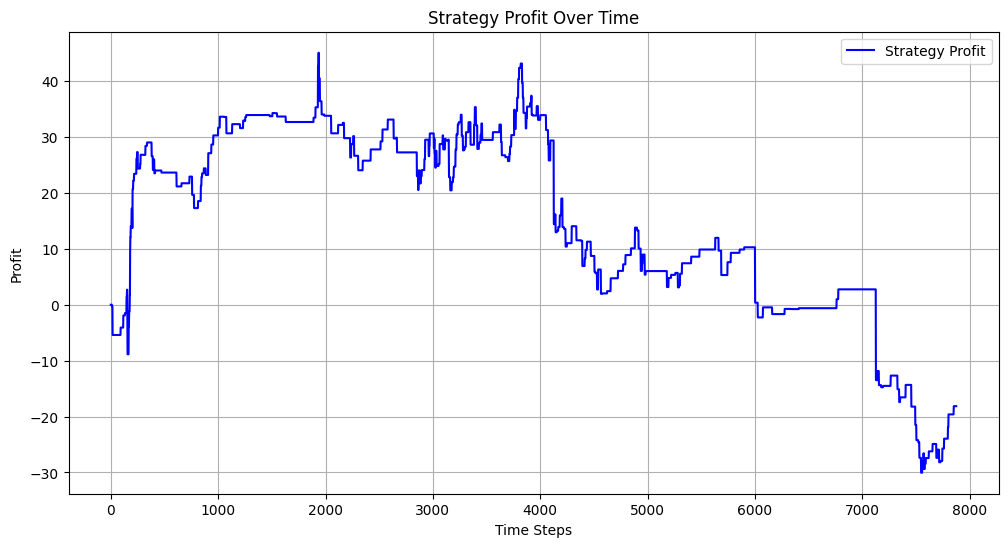

In [8]:
profit_ts, buy_signal, sell_signal = strategy_profit_with_stop_loss(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band, lower_band, upper_band, stop_loss=0.1)
plt.figure(figsize=(12, 6))
plt.plot(profit_ts, label='Strategy Profit', color='blue')

plt.legend()
plt.title('Strategy Profit Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.grid()
plt.show()


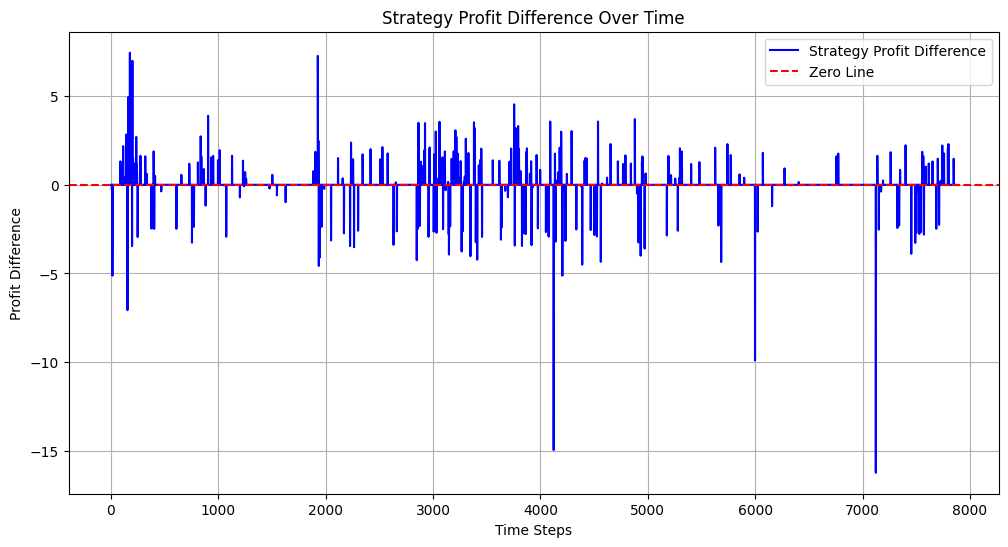

In [9]:
profit_ts_diff = np.diff(profit_ts)
plt.figure(figsize=(12, 6))

plt.plot(profit_ts_diff, label='Strategy Profit Difference', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.legend()
plt.title('Strategy Profit Difference Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Profit Difference')
plt.grid()
plt.show()

In [10]:
list_of_periods = [5, 10, 15, 20]
list_of_k = [1, 1.5, 2]

def calculate_profit_for_k_and_period(k, period, closing_prices, stop_loss = 0.1):
    """
    Calculate profit for a given k and period.
    
    :param k: Multiplier for the volatility bands
    :param period: Period for the rolling window
    :param closing_prices: Closing prices of the asset
    :param stop_loss: Stop loss percentage
    :return: Profit time series, buy signals, sell signals
    """
    mid_band = closing_prices.rolling(window=period).mean()
    volatility = closing_prices.rolling(window=period).std()
    
    upper_band = mid_band + k * volatility
    lower_band = mid_band - k * volatility
    
    return strategy_profit_with_stop_loss(closing_prices, mid_band, lower_band, upper_band, stop_loss)[0]
profit_for_different_strategies = []
for period in list_of_periods:
    for k in list_of_k:
        profit_for_different_strategies.append(calculate_profit_for_k_and_period(k, period, df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'], stop_loss=0.1))
profit_for_different_strategies = np.array(profit_for_different_strategies)
        

/tmp/ipykernel_1226/1000589822.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if closing_prices[i] < lower_band[i]:
/tmp/ipykernel_1226/1000589822.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif closing_prices[i] > upper_band[i]:
/tmp/ipykernel_1226/1000589822.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price = closing_prices[i]
/tmp/ipykernel_1226/1000589822.py:23: FutureWarning: Series.__getitem__ tr

In [11]:
list_of_returns = []
for i in range(profit_for_different_strategies.shape[0]):
    list_of_returns.append(np.diff(profit_for_different_strategies[i]))


In [12]:
benchmark_returns = np.array(profit_ts_diff)
benchmark_losses = -benchmark_returns
strategy_losses = -np.array(list_of_returns).T
spa = SPA(benchmark_losses, strategy_losses)
spa.compute()
better_model_indices = spa.better_models(pvalue=0.05, pvalue_type="lower")
print("Indices of strategies that are better than the benchmark:", better_model_indices)

Indices of strategies that are better than the benchmark: []


In [13]:
def strategy_profit_for_no_of_trades(closing_prices, mid_band, lower_band, upper_band, stop_loss = 0.1):
    
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    entry_price = 0
    stop_loss_price = 0
    profit_ts = []
    no_of_trades = 0
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 - stop_loss)/ 100
                buy_signal.append(i)
                no_of_trades += 1
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 + stop_loss)/ 100
                sell_signal.append(i)
                no_of_trades += 1
        elif position == 'long':
            if closing_prices[i] > mid_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
            elif closing_prices[i] < stop_loss_price :
                profit -= entry_price - closing_prices[i]
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < mid_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
            elif closing_prices[i] > stop_loss_price :
                profit -= closing_prices[i] - entry_price
                position = None
                buy_signal.append(i)

        profit_ts.append(profit)
    return no_of_trades

In [14]:
print(strategy_profit_for_no_of_trades(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band, lower_band, upper_band, stop_loss=0.1))

270


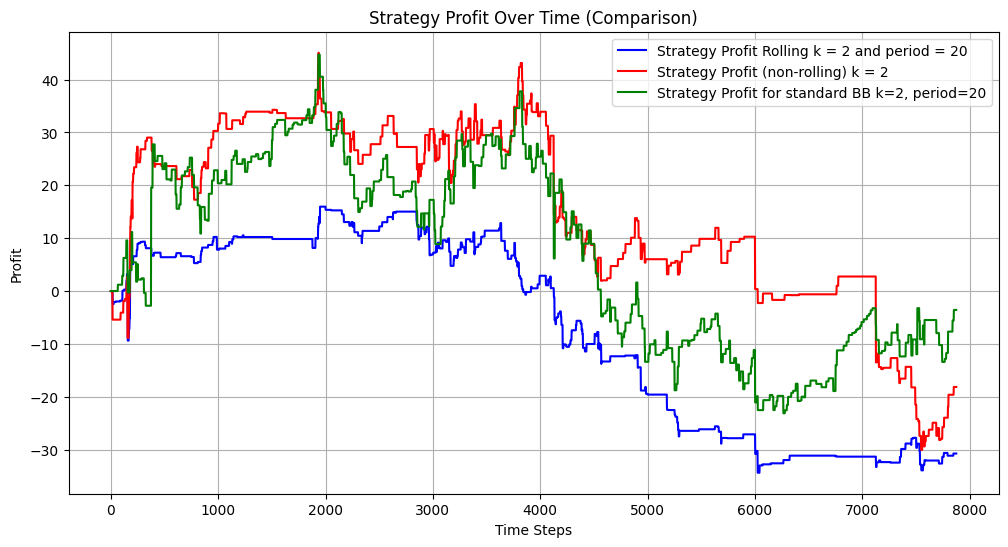

In [29]:
# extract daa from '/home/vishi/bolinger/profit_ts_rolling.npy'
profit_ts_rolling = np.load('/home/vishi/bolinger/profit_ts_rolling.npy')
plt.figure(figsize=(12, 6))
plt.plot(profit_ts_rolling, label='Strategy Profit Rolling k = 2 and period = 20', color='blue')
plt.plot(profit_ts, label='Strategy Profit (non-rolling) k = 2', color='red')
plt.plot(profit_for_different_strategies[-1], label='Strategy Profit for standard BB k=2, period=20', color='green')
plt.legend()
plt.title('Strategy Profit Over Time (Comparison)')
# zoom between 0 and 500
# plt.xlim(0, 500)
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.grid()
plt.show()


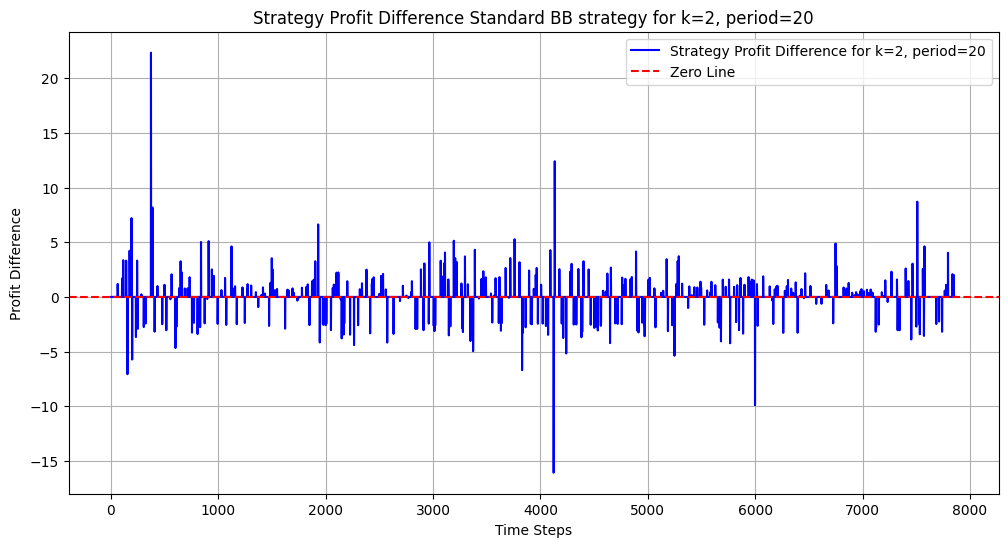

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(np.diff(profit_for_different_strategies[-1]), label='Strategy Profit Difference for k=2, period=20', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.legend()
plt.title('Strategy Profit Difference Standard BB strategy for k=2, period=20')
# zoom between 0 and 500
# plt.xlim(0, 500)
plt.xlabel('Time Steps')
plt.ylabel('Profit Difference')
plt.grid()
plt.show()

In [22]:
def calculate_profit_for_k_and_period_modified(k, period, closing_prices, stop_loss = 0.1):
    """
    Calculate profit for a given k and period.
    
    :param k: Multiplier for the volatility bands
    :param period: Period for the rolling window
    :param closing_prices: Closing prices of the asset
    :param stop_loss: Stop loss percentage
    :return: Profit time series, buy signals, sell signals
    """
    mid_band = closing_prices.rolling(window=period).mean()
    volatility = closing_prices.rolling(window=period).std()
    
    upper_band = mid_band + k * volatility
    lower_band = mid_band - k * volatility
    
    return strategy_profit_for_no_of_trades(closing_prices, mid_band, lower_band, upper_band, stop_loss)

calculate_profit_for_k_and_period_modified(2, 20, df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'], stop_loss=0.1)

/tmp/ipykernel_1226/1311043386.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if closing_prices[i] < lower_band[i]:
/tmp/ipykernel_1226/1311043386.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif closing_prices[i] > upper_band[i]:
/tmp/ipykernel_1226/1311043386.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price = closing_prices[i]
/tmp/ipykernel_1226/1311043386.py:35: FutureWarning: Series.__getitem__ tr

340

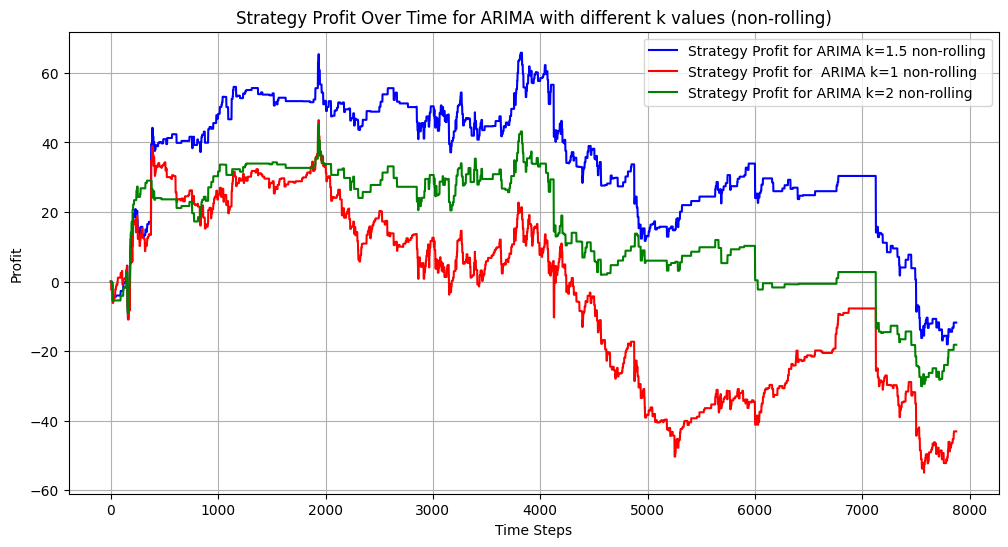

In [30]:
upper_band_1_5 = np.array(prediction_arima) + 1.5 * np.array(volatility_prediction)
lower_band_1_5 = np.array(prediction_arima) - 1.5 * np.array(volatility_prediction)
mid_band_1_5 = np.array(prediction_arima)

upper_band_1 = np.array(prediction_arima) +   np.array(volatility_prediction)
lower_band_1 = np.array(prediction_arima) -   np.array(volatility_prediction)
mid_band_1 = np.array(prediction_arima)


profit_ts_1_5, buy_signal_1_5, sell_signal_1_5 = strategy_profit_with_stop_loss(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band_1_5, lower_band_1_5, upper_band_1_5, stop_loss=0.1)  
profit_ts_1, buy_signal_1, sell_signal_1 = strategy_profit_with_stop_loss(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band_1, lower_band_1, upper_band_1, stop_loss=0.1)
plt.figure(figsize=(12, 6))
plt.plot(profit_ts_1, label='Strategy Profit for  ARIMA k=1 non-rolling', color='red')
plt.plot(profit_ts_1_5, label='Strategy Profit for ARIMA k=1.5 non-rolling', color='blue')
plt.plot(profit_ts, label='Strategy Profit for ARIMA k=2 non-rolling', color='green')
plt.legend()
plt.title('Strategy Profit Over Time for ARIMA with different k values (non-rolling)')
# zoom between 0 and 500
# plt.xlim(0, 500)
plt.xlabel('Time Steps')
plt.ylabel('Profit')
plt.grid()
plt.show()

In [27]:
print("Number of trades for different strategies:")
print("k=1.5, period=20:", strategy_profit_for_no_of_trades(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band_1_5, lower_band_1_5, upper_band_1_5, stop_loss=0.1))
print("k=1, period=20:", strategy_profit_for_no_of_trades(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band_1, lower_band_1, upper_band_1, stop_loss=0.1))
print("k=2, period=20:", strategy_profit_for_no_of_trades(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band, lower_band, upper_band, stop_loss=0.1))

Number of trades for different strategies:
k=1.5, period=20: 478
k=1, period=20: 807
k=2, period=20: 270


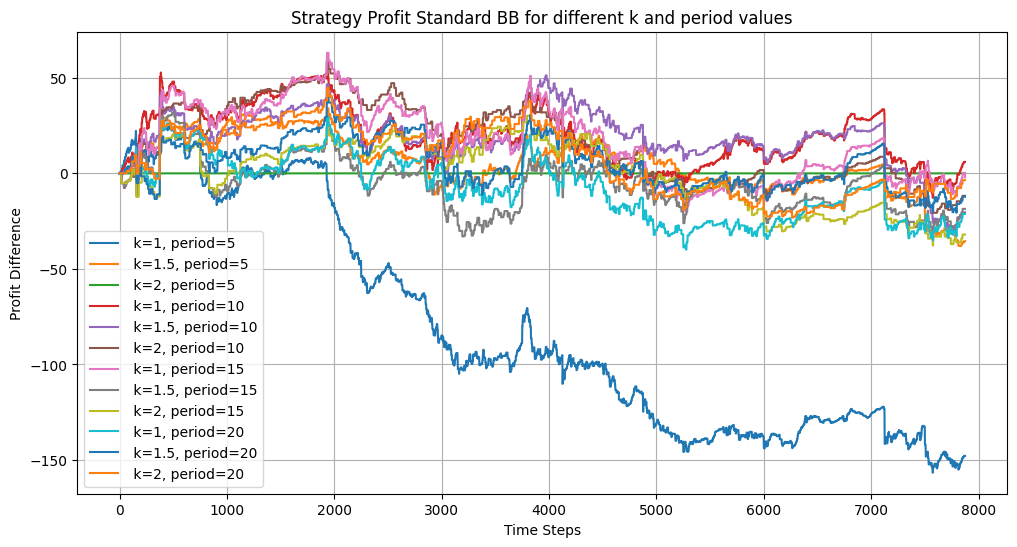

In [33]:
plt.figure(figsize=(12, 6))
for i in range(profit_for_different_strategies.shape[0]):
    plt.plot(profit_for_different_strategies[i], label=f' k={list_of_k[i%3]}, period={list_of_periods[i//3]}')
plt.legend()
plt.title('Strategy Profit Standard BB for different k and period values')
# zoom between 0 and 500
# plt.xlim(0, 500)
plt.xlabel('Time Steps')
plt.ylabel('Profit Difference')
plt.grid()
plt.show()

In [34]:
def strategy_profit_for_no_of_trades_ts(closing_prices, mid_band, lower_band, upper_band, stop_loss = 0.1):
    
    profit = 0
    buy_signal = []
    sell_signal = []
    position = None  # None means no position, 'long' means holding a long position
    entry_price = 0
    stop_loss_price = 0
    profit_ts = []
    no_of_trades = 0
    trades_ts = []
    for i in range(closing_prices.shape[0]):
        if position is None:
            if closing_prices[i] < lower_band[i]:
                position = 'long'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 - stop_loss)/ 100
                buy_signal.append(i)
                no_of_trades += 1
            elif closing_prices[i] > upper_band[i]:
                position = 'short'
                entry_price = closing_prices[i]
                stop_loss_price = entry_price * (100 + stop_loss)/ 100
                sell_signal.append(i)
                no_of_trades += 1
        elif position == 'long':
            if closing_prices[i] > mid_band[i]:
                profit += closing_prices[i] - entry_price
                position = None
                sell_signal.append(i)
            elif closing_prices[i] < stop_loss_price :
                profit -= entry_price - closing_prices[i]
                position = None
                sell_signal.append(i)
        elif position == 'short':
            if closing_prices[i] < mid_band[i]:
                profit += entry_price - closing_prices[i]
                position = None
                buy_signal.append(i)
            elif closing_prices[i] > stop_loss_price :
                profit -= closing_prices[i] - entry_price
                position = None
                buy_signal.append(i)

        profit_ts.append(profit)
        trades_ts.append(no_of_trades)
    return trades_ts


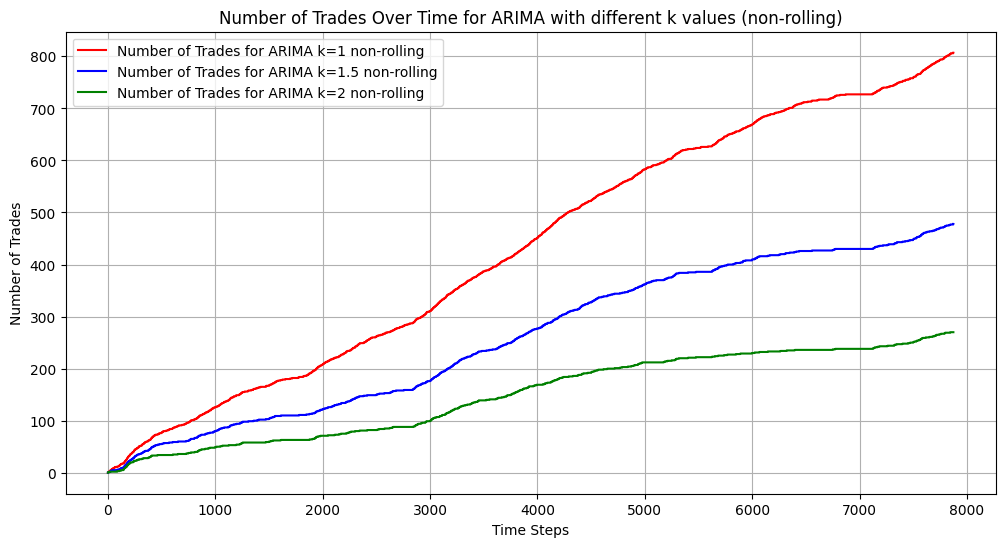

In [35]:
trades_ts_1 = strategy_profit_for_no_of_trades_ts(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band_1, lower_band_1, upper_band_1, stop_loss=0.1)    
trades_ts_1_5 = strategy_profit_for_no_of_trades_ts(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band_1_5, lower_band_1_5, upper_band_1_5, stop_loss=0.1)    
trades_ts_2 = strategy_profit_for_no_of_trades_ts(
    np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'])
    , mid_band, lower_band, upper_band, stop_loss=0.1)
plt.figure(figsize=(12, 6))
plt.plot(trades_ts_1, label='Number of Trades for ARIMA k=1 non-rolling', color='red')
plt.plot(trades_ts_1_5, label='Number of Trades for ARIMA k=1.5 non-rolling', color='blue')
plt.plot(trades_ts_2, label='Number of Trades for ARIMA k=2 non-rolling', color='green')
plt.legend()
plt.title('Number of Trades Over Time for ARIMA with different k values (non-rolling)')
# zoom between 0 and 500
# plt.xlim(0, 500)
plt.xlabel('Time Steps')
plt.ylabel('Number of Trades')
plt.grid()
plt.show()

/tmp/ipykernel_1226/3543512330.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if closing_prices[i] < lower_band[i]:
/tmp/ipykernel_1226/3543512330.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif closing_prices[i] > upper_band[i]:
/tmp/ipykernel_1226/3543512330.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price = closing_prices[i]
/tmp/ipykernel_1226/3543512330.py:27: FutureWarning: Series.__getitem__ tr

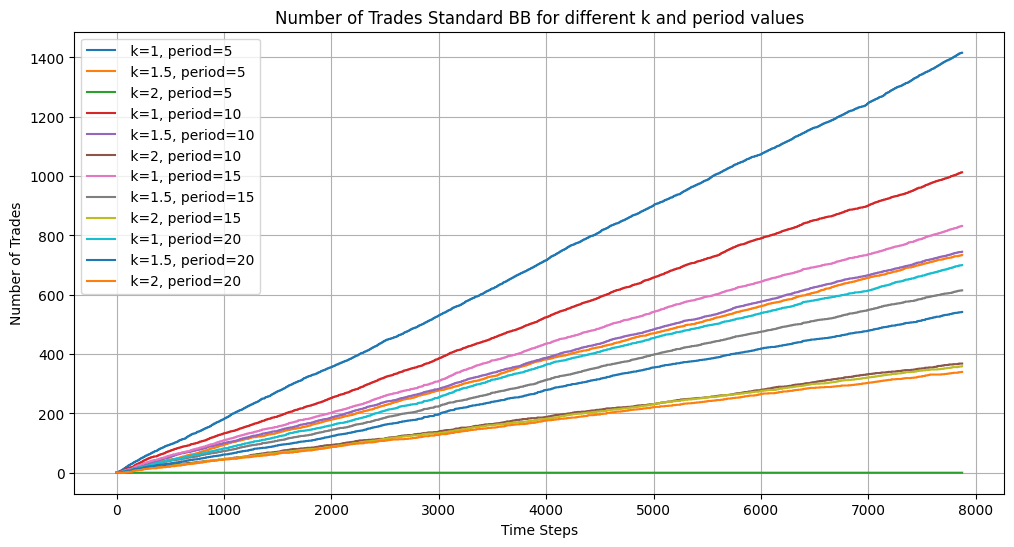

In [36]:
def calculate_profit_for_k_and_period_modified_ts(k, period, closing_prices, stop_loss = 0.1):
    """
    Calculate profit for a given k and period.
    
    :param k: Multiplier for the volatility bands
    :param period: Period for the rolling window
    :param closing_prices: Closing prices of the asset
    :param stop_loss: Stop loss percentage
    :return: Profit time series, buy signals, sell signals
    """
    mid_band = closing_prices.rolling(window=period).mean()
    volatility = closing_prices.rolling(window=period).std()
    
    upper_band = mid_band + k * volatility
    lower_band = mid_band - k * volatility
    
    return strategy_profit_for_no_of_trades_ts(closing_prices, mid_band, lower_band, upper_band, stop_loss)

plt.figure(figsize=(12, 6))
for i in range(profit_for_different_strategies.shape[0]):
    plt.plot(calculate_profit_for_k_and_period_modified_ts(
        list_of_k[i%3], list_of_periods[i//3], df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'], stop_loss=0.1),
        label=f' k={list_of_k[i%3]}, period={list_of_periods[i//3]}')
plt.legend()
plt.title('Number of Trades Standard BB for different k and period values')
# zoom between 0 and 500
# plt.xlim(0, 500)
plt.xlabel('Time Steps')
plt.ylabel('Number of Trades')
plt.grid()
plt.show()

In [41]:
for i in range(profit_for_different_strategies.shape[0]):
    print(f" k={list_of_k[i%3]}, period={list_of_periods[i//3]}: {calculate_profit_for_k_and_period_modified(list_of_k[i%3], list_of_periods[i//3], df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-03-03 23:00'], stop_loss=0.1)}")

/tmp/ipykernel_1226/1311043386.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if closing_prices[i] < lower_band[i]:
/tmp/ipykernel_1226/1311043386.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif closing_prices[i] > upper_band[i]:
/tmp/ipykernel_1226/1311043386.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  entry_price = closing_prices[i]
/tmp/ipykernel_1226/1311043386.py:26: FutureWarning: Series.__getitem__ tr

 k=1, period=5: 1416
 k=1.5, period=5: 734
 k=2, period=5: 0
 k=1, period=10: 1013
 k=1.5, period=10: 745
 k=2, period=10: 368
 k=1, period=15: 832
 k=1.5, period=15: 615
 k=2, period=15: 359
 k=1, period=20: 700
 k=1.5, period=20: 542
 k=2, period=20: 340


In [42]:
def calculate_performance_metrics(profit_ts):
    """    Calculate performance metrics for the given returns.
    :param returns: Array of returns    
    :return: Dictionary of performance metrics
    """
    returns = np.array(np.diff(profit_ts))
    sharpe_ratio = np.mean(returns) / np.std(returns)
    sortino_ratio = np.mean(returns) / np.std(returns[returns < 0])
    max_drawdown = np.max(np.maximum.accumulate(returns) - returns)
    cagr = (1 + returns[-1]) ** (252 / len(returns)) - 1
    calmar_ratio = cagr / max_drawdown if max_drawdown != 0 else np.nan
    volatility = np.std(returns)

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'CAGR': cagr,
        'Calmar Ratio': calmar_ratio,
        'Volatility': volatility
    }

In [43]:
metric_1_non_rolling = calculate_performance_metrics(profit_ts_1)
metric_1_5_non_rolling = calculate_performance_metrics(profit_ts_1_5)
metric_2_non_rolling = calculate_performance_metrics(profit_ts) 
metric_bb = []
for i in range(profit_for_different_strategies.shape[0]):
    metric_bb.append(calculate_performance_metrics(profit_for_different_strategies[i]))

    

/tmp/ipykernel_1226/2128823775.py:7: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(returns) / np.std(returns)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1226/2128823775.py:10: RuntimeWarning: invalid value encountered in scalar power
  cagr = (1 + returns[-1]) ** (252 / len(returns)) - 1


In [44]:
print(metric_2_non_rolling)

{'Sharpe Ratio': np.float64(-0.00440254554045621), 'Sortino Ratio': np.float64(-0.0009844970999993135), 'Max Drawdown': np.float64(23.69000000000051), 'CAGR': np.float64(0.0), 'Calmar Ratio': np.float64(0.0), 'Volatility': np.float64(0.5235731439746933)}


In [45]:
print(metric_bb[-1])

{'Sharpe Ratio': np.float64(-0.0006999660763380957), 'Sortino Ratio': np.float64(-0.0002593663334163173), 'Max Drawdown': np.float64(38.43000000000029), 'CAGR': np.float64(0.0), 'Calmar Ratio': np.float64(0.0), 'Volatility': np.float64(0.6486398747018733)}
